# Generate Input - MIMS

This script manages all the requirements of the raw MIMS data processing. The raw data files are _.xlh_. The script first loads the individual _.xlh_ files via __processFile()__. Next the calibration periods are pulled out leading to two datasets: _data.main_ and _data.cal_. The datasets are averaged and then saved for use in the ___Main Data Merge___ script.

### Steps:

1. __Setup__
 * 1b. Calibration

2. __Run__
 * Load the data
 * Filter and average

3. __Save__

4. __Visualize__
 * Plot signal and calibrations

5. __Vertical Profiles__
 * Load and parse vertical profiles
 * Load Log files
 * 5b. save
 
 
 
---
### Functions:
__make.calibration.sequence(__t1, t2__)__
- Takes two integers (excel date codes) and generates a regular sequence of calibration periods. Useful when calibrations are on a timer or otherwise very predictable.

__processFile(__filepath, file, cals, make.img = FALSE, rm.cals = FALSE__)__

__take.avg(__x, n = 60__)__



In [18]:
source('source.r')

Packages Loaded:
ncdf4 R.matlab openxlsx RColorBrewer compiler lattice geosphere readxl data.table rworldmap rworldxtra


Loading required package: R.matlab
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘R.matlab’”Loading required package: geosphere
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘geosphere’”

---
# 1. Setup

In [19]:
input.dir = 'Raw data/MIMS/'

## Generate list of files in the directory
file.list = list.files(input.dir)

## split file.list into usable lists
file.list = file.list[grepl('.xlh', file.list)]
file.list = file.list[!grepl('profile', file.list)]
file.list = file.list[!grepl('csv', file.list)]
length(file.list)

[1] 75

In [20]:
make.calibration.sequence = function(t1, t2) {
    cals = c(t1:t2)
    cals = c(cals + 0.0423, cals + 0.1674,
             cals + 0.2785, cals + 0.4175,
             cals + 0.5425, cals + 0.6676,
             cals + 0.7926, cals + 0.917)
    cals = data.frame(start = cals, stop = cals + 20/(24*60))
    cals$start = conv_excel_time(cals$start)
    cals$stop = conv_excel_time(cals$stop)
    cals
}

processFile = function(filepath, file, cals, make.img = FALSE, rm.cals = FALSE) {
    
    ## Empty dataframe to ensure consistency
    dat = data.frame(cycle = 0, time = 0, X18 = 0, X28 = 0, X32 = 0, X40 = 0, X44 = 0, 
                      X45 = 0, TP = 0, N2.Ar = 0, O2.Ar = 0, N2.O2 = 0, BK.v = 0, BK.a = 0, BK.w = 0)
    
    temp = fread(paste0(input.dir, file), skip=9)
    colnames(temp) = colnames(dat)
    dat = rbind(dat, temp)

    dat$Flag = 1
    dat = dat[-1,]
    dat$time = conv_excel_time(dat$time)

    #### Flag values
    ## 
    ## 1: default
    ## 2: calibration period 
    ## 3: Rejected with N minutes of switch.
    ##
    for (j in 1:nrow(cals)) {
        dt = as.numeric(difftime(dat$time, cals$start[j], units='mins'))
        dt2 = as.numeric(difftime(dat$time, cals$stop[j], units='mins'))
        
        l = which(dt > 0 & dt2 < 0)
        dat$Flag[l] = 2 # cal
        
        l = which(abs(dt) < 4)
        dat$Flag[l] = 3 # reject
        
        l = which(abs(dt2) < 4)
        dat$Flag[l] = 3 # reject
        
    }
    
    ## Optional output of images for visual inspection, color coded by flag value
    if (make.img) {
        cols = c('black', 'orange', 'red')
    
        png(paste0('Output/MIMS/', file, '.png'))
        plot(dat$time, dat$O2.Ar, col=cols[dat$Flag], pch=20, ylab='O2/Ar', xlab='', main=file, cex=0.4)
        dev.off()
    }
    
    ## Removes the samples located at the start or end of a calibration cycle.
    if (rm.cals) {
        dat = dat[dat$Flag < 3,]
    }
    
    ## Can conv time to excel time if useful 
    #dat$time = abs(as.numeric(difftime(as.POSIXct(as.Date(0, origin="1899-12-30", tz=tz)), dat$time, units = 'days')))
    
    return(dat)
}

#### take.avg
##
## This Function accepts a data.frame (x) and returns a 30 second averaged output.
## It assumes only columns 3 and up should be averaged (e.g. column 2 is time). It
## Also removes gross outliers (O2/Ar ratios over 40 and less than 10).

take.avg = function(x, n = 60) {
    i = 1
    
    ## Trim the data
    x = as.data.frame(x[x$O2.Ar > 10 & x$O2.Ar < 40,])
    
    ## Averaging Loop
    while (i < nrow(x)) {
        dt = as.numeric(difftime(x$time[i], x$time, units = 'sec'))
        
        ## Determine which entries to average
        l = which(dt > dt[i] & dt - dt[i] <= n)
        temp = apply(x[l, 3:ncol(x)], 2, function(t) {mean(t, na.rm = TRUE)})
        
        ## Replace with average then remove all other lines
        if (length(l) > 1) {
            x[i, c(3:ncol(x))] = temp
            l = l[l != i]
            if (length(l) > 1) {
                x = x[-l,]
            }
            if (max(dt[l]) < n/2) {
                x$Flag[l] = 3
            }
        } else {
            x$Flag[l] = 3
        }
        i = i + 1
    }
    x
}

## 1b. Make calibration

In [21]:
make.calibration = function(path) {
    cals = make.calibration.sequence(42894, 42917)

    cal.file = read.xlsx(path, sheet = 'Sheet2')
    cal.file$start = conv_excel_time(cal.file$start)
    cal.file$stop = conv_excel_time(cal.file$stop)

    rbind(cals, cal.file)
}

cals = make.calibration('Raw Data/MIMS/Calibration MIMS hand readout.xlsx')

In [22]:
data = processFile(input.dir, file.list[20], cals, make.img = TRUE)
str(data)

Classes ‘data.table’ and 'data.frame':	20965 obs. of  16 variables:
 $ cycle: num  279439 279440 279441 279442 279443 ...
 $ time : POSIXct, format: "2017-06-08 20:00:39" "2017-06-08 20:00:40" ...
 $ X18  : num  2.87e-08 2.88e-08 2.87e-08 2.87e-08 2.87e-08 ...
 $ X28  : num  4.86e-08 4.87e-08 4.85e-08 4.85e-08 4.86e-08 ...
 $ X32  : num  3.07e-08 3.07e-08 3.05e-08 3.06e-08 3.06e-08 ...
 $ X40  : num  9.79e-10 9.79e-10 9.75e-10 9.75e-10 9.78e-10 ...
 $ X44  : num  5.22e-10 5.22e-10 5.18e-10 5.18e-10 5.22e-10 ...
 $ X45  : num  7.05e-12 7.11e-12 7.00e-12 7.21e-12 6.64e-12 ...
 $ TP   : num  2.79e-06 2.77e-06 2.77e-06 2.77e-06 2.77e-06 ...
 $ N2.Ar: num  49.7 49.8 49.7 49.7 49.7 ...
 $ O2.Ar: num  31.4 31.3 31.3 31.3 31.3 ...
 $ N2.O2: num  1.58 1.59 1.59 1.59 1.59 ...
 $ BK.v : num  0 0 0 0 0 0 0 0 0 0 ...
 $ BK.a : num  0 0 0 0 0 0 0 0 0 0 ...
 $ BK.w : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Flag : num  1 1 1 1 1 1 1 1 1 1 ...
 - attr(*, ".internal.selfref")=<externalptr> 


# 2. Test and Run
First time through, let's load the data, apply calibration filter and plot the results. Are we getting it right?

Then we can run it for a data merge, removing data between calibration and non-calibration periods.

In [25]:
run = function(file.list, cals, compile = FALSE, make.img = FALSE, rm.cals = FALSE, from.rdata = FALSE) {
    
    if (from.rdata) {
        load(paste0('RStates/MIMS/', file.list[1], '.rdata'))
        new.data = data
        
        for (i in 2:length(file.list)) {
            load(paste0('RStates/MIMS/', file.list[i], '.rdata'))
            new.data = rbind(new.data, data)
        }
        return(new.data)
    }
    
    data = processFile(input.dir, file.list[1], cals, make.img = make.img, rm.cals = rm.cals)
    if (!compile) {
        save(data, file=paste0('RStates/MIMS/', file.list[1], '.rdata'))
    }
    
    for (i in 2:length(file.list)) {
        if (compile) {
            data = rbind(data, processFile(input.dir, file.list[i], cals, make.img = FALSE, rm.cals = rm.cals))
        } else {
            data = processFile(input.dir, file.list[i], cals, make.img = make.img, rm.cals = rm.cals)
            save(data, file=paste0('RStates/MIMS/', file.list[i], '.rdata'))
        }
    }
    if (compile){
        return(data)
    }
    return(0)
}

In [26]:
run(file.list, cals, make.img = TRUE, compile = FALSE)

[1] 0

In [9]:
data = run(file.list, cals, compile = TRUE, rm.cals = TRUE)

In [27]:
data = run(file.list, cals, compile = TRUE, rm.cals = TRUE, from.rdata = TRUE)

__Apply averaging__ : This will take a while!

In [28]:
print('Starting Main Averaging:')
data.main = take.avg(data[data$Flag == 1,], n = 10)

print('Done.')
print('Starting Cal Averaging:')
data.cal = take.avg(data[data$Flag == 2,], n = 60)
print('Done.')

[1] "Starting Main Averaging:"
[1] "Done."
[1] "Starting Cal Averaging:"
[1] "Done."


In [29]:
str(data)

Classes 'data.table' and 'data.frame':	1699810 obs. of  16 variables:
 $ cycle: num  0 1 2 3 4 5 6 7 8 9 ...
 $ time : POSIXct, format: "2017-05-31 13:19:56" "2017-05-31 13:19:57" ...
 $ X18  : num  2.05e-07 2.04e-07 2.04e-07 2.03e-07 2.02e-07 ...
 $ X28  : num  2.60e-07 2.58e-07 2.57e-07 2.56e-07 2.56e-07 ...
 $ X32  : num  1.39e-07 1.37e-07 1.37e-07 1.37e-07 1.37e-07 ...
 $ X40  : num  4.84e-09 4.80e-09 4.78e-09 4.77e-09 4.77e-09 ...
 $ X44  : num  3.82e-09 3.80e-09 3.79e-09 3.77e-09 3.76e-09 ...
 $ X45  : num  6.34e-11 6.27e-11 6.21e-11 6.22e-11 6.16e-11 ...
 $ TP   : num  4.39e-06 4.39e-06 4.39e-06 4.41e-06 4.43e-06 ...
 $ N2.Ar: num  53.7 53.8 53.8 53.6 53.7 ...
 $ O2.Ar: num  28.7 28.6 28.6 28.7 28.7 ...
 $ N2.O2: num  1.87 1.88 1.88 1.87 1.87 ...
 $ BK.v : num  0 0 0 0 0 0 0 0 0 0 ...
 $ BK.a : num  0 0 0 0 0 0 0 0 0 0 ...
 $ BK.w : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Flag : num  1 1 1 1 1 1 1 1 1 1 ...
 - attr(*, ".internal.selfref")=<externalptr> 


---
# 3. Save

In [30]:
## Write rdata files
mims = list(sample = data.main, cal = data.cal)
save(mims, file='RStates/MIMS.10sec.1min.rdata')

## Write human-readable xlsx files
#write.xlsx(mims, 'Input Data/MIMS-Preliminary.xlsx')

In [112]:
load(file='RStates/MIMS.rdata')

---
# 4. Visualize Data

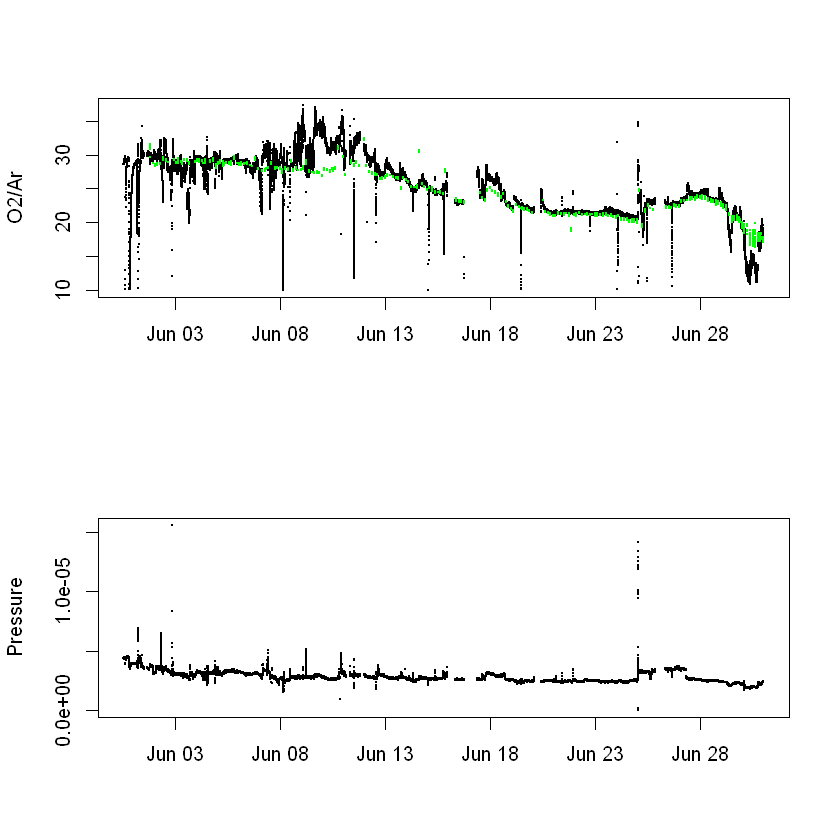

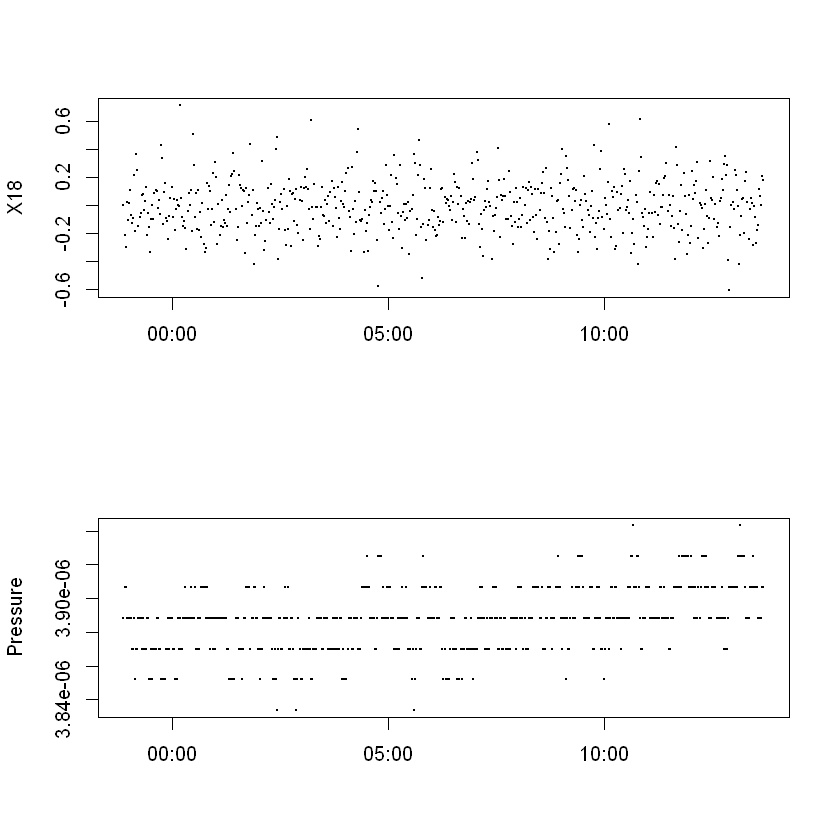

In [31]:
#pdf('Output/MIMS Module - Overview.pdf')

par(mfrow=c(2,1))
plot(data.main$time, data.main$O2.Ar, pch=16, cex=0.2, ylab='O2/Ar', xlab='')
points(data.cal$time, data.cal$O2.Ar, col='green', pch=16, cex=0.2)

plot(data.main$time, data.main$TP, pch=16, cex=0.2, ylab='Pressure', xlab='')

l = c(21000:21600)
plot(data$time[l], c(0, diff(data$X18[l]))*1e9, pch=16, cex=0.2, ylab='X18', xlab='')

plot(data$time[l], data$TP[l], pch=16, cex=0.2, ylab='Pressure', xlab='')

#dev.off()

---
# Drift Correction

In [3]:
load('RStates/MIMS.10sec.1min.rdata')

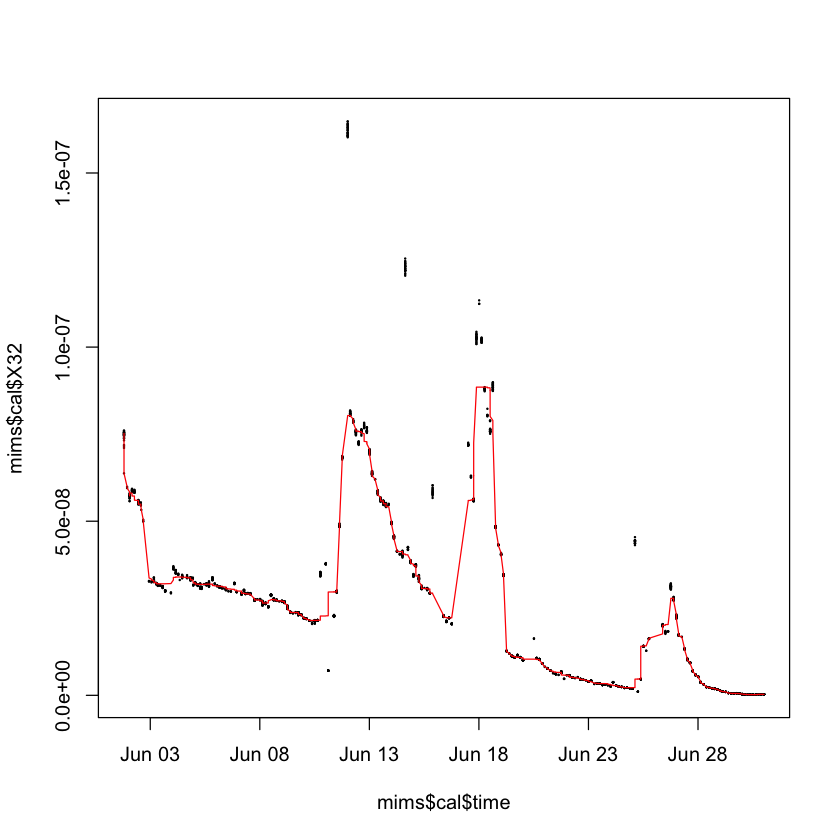

In [17]:
plot(mims$cal$time, mims$cal$X32, pch = 20, cex=0.2)
lines(mims$cal$time, runmed(mims$cal$X32, k = 101), cex=0.2, pch=20, col='red')